In [29]:
#Importing required libraries
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

In [30]:
#Reading in the xlsx file 

data = pd.read_excel('Data.xlsx', sheet_name=None)

# loop through the dictionary and save csv
for sheet_name, df in data.items():
  df.to_csv(f'{sheet_name}.csv')

In [31]:
flight  = pd.read_csv("flight dates.csv")
planting  = pd.read_csv("planting.csv")
plant  =  pd.read_csv("plants.csv")
weather = pd.read_csv("weather.csv")

In [32]:
plant.shape

(4859, 16)

In [33]:
plant.columns

Index(['Unnamed: 0', 'Batch Number', 'Plant Date', 'Class', 'Fresh Weight (g)',
       'Head Weight (g)', 'Radial Diameter (mm)', 'Polar Diameter (mm)',
       'Diameter Ratio', 'Leaves', 'Density (kg/L)', 'Leaf Area (cm^2)',
       'Square ID', 'Check Date', 'Flight Date', 'Remove'],
      dtype='object')

In [34]:
plant.drop(["Unnamed: 0"],axis  = 1,inplace  = True)
flight.drop(["Unnamed: 0"],axis  = 1,inplace  = True)
planting.drop(["Unnamed: 0"],axis  = 1,inplace  = True)
weather.drop(["Unnamed: 0"],axis  = 1,inplace  = True)

In [35]:
plant.columns = ['BatchNumber', 'PlantDate', 'Class', 'FreshWeight(g)',
       'HeadWeight(g)', 'RadialDiameter(mm)', 'PolarDiameter(mm)',
       'DiameterRatio', 'Leaves', 'Density(kg/L)', 'LeafArea(cm^2)',
       'SquareID', 'CheckDate', 'FlightDate', 'Remove']

In [36]:
flight.columns  = ['BatchNumber', 'FlightDate']

In [37]:
#Mapping Batch Number to flight date
plant.FlightDate  = plant['BatchNumber'].map(flight.set_index('BatchNumber')['FlightDate'])

In [38]:
planting.head()

,Crop,Column2,Column3,Plant_Date,Column1,Region,Column4,Planting_Batch,Volume_Planted,Planting_Wk
0,3,NaN,NaN,2020-02-06 00:00:00,NaN,0.0,NaN,392,198912.0,6.0
1,3,NaN,NaN,2020-02-07 00:00:00,NaN,0.0,NaN,503,63840.0,6.0
2,3,NaN,NaN,2020-02-07 00:00:00,NaN,0.0,NaN,614,179928.0,6.0
3,3,NaN,NaN,2020-02-08 00:00:00,NaN,0.0,NaN,725,200256.0,6.0
4,3,NaN,NaN,2020-02-10 00:00:00,NaN,0.0,NaN,770,13944.0,7.0


In [39]:
planting.Crop.value_counts()

3          485
4          434
8          266
0          258
6          162
7           84
1           65
2           39
5           28
Ice 307     25
Ice 311     25
Ice 310     22
Ice 306     20
Ice 309     20
Ice 305     19
565          1
Name: Crop, dtype: int64

In [40]:
plant

,BatchNumber,PlantDate,Class,FreshWeight(g),HeadWeight(g),RadialDiameter(mm),PolarDiameter(mm),DiameterRatio,Leaves,Density(kg/L),LeafArea(cm^2),SquareID,CheckDate,FlightDate,Remove
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,10.0,NaN,185.0,208,2020-04-30,2020-04-30,NaN
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,NaN,11.0,NaN,156.0,208,2020-04-30,2020-04-30,NaN
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,NaN,12.0,NaN,137.0,208,2020-04-30,2020-04-30,NaN
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,10.0,NaN,225.0,208,2020-04-30,2020-04-30,NaN
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,11.0,NaN,157.0,208,2020-04-30,2020-04-30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854,738,2020-08-27,4,284.0,12.0,50.0,55.0,0.909091,NaN,NaN,430.0,1172,2020-10-20,NaN,NaN
4855,738,2020-08-27,5,199.0,8.0,45.0,85.0,0.529412,NaN,NaN,358.0,1172,2020-10-20,NaN,NaN
4856,738,2020-08-27,3,280.0,23.0,60.0,80.0,0.750000,NaN,NaN,417.0,1172,2020-10-20,NaN,NaN
4857,738,2020-08-27,4,247.0,10.0,45.0,80.0,0.562500,NaN,NaN,413.0,1172,2020-10-20,NaN,NaN


In [41]:
plant.isnull().sum()

BatchNumber              0
PlantDate              174
Class                    0
FreshWeight(g)           1
HeadWeight(g)          105
RadialDiameter(mm)     105
PolarDiameter(mm)      105
DiameterRatio          107
Leaves                4759
Density(kg/L)          187
LeafArea(cm^2)           2
SquareID                 0
CheckDate                0
FlightDate            1459
Remove                4789
dtype: int64

In [42]:
flight.head()

,BatchNumber,FlightDate
0,402,2020-04-30
1,408,2020-04-30
2,409,2020-04-30
3,466,2020-07-01
4,467,2020-07-01


In [43]:
planting.head()

,Crop,Column2,Column3,Plant_Date,Column1,Region,Column4,Planting_Batch,Volume_Planted,Planting_Wk
0,3,NaN,NaN,2020-02-06 00:00:00,NaN,0.0,NaN,392,198912.0,6.0
1,3,NaN,NaN,2020-02-07 00:00:00,NaN,0.0,NaN,503,63840.0,6.0
2,3,NaN,NaN,2020-02-07 00:00:00,NaN,0.0,NaN,614,179928.0,6.0
3,3,NaN,NaN,2020-02-08 00:00:00,NaN,0.0,NaN,725,200256.0,6.0
4,3,NaN,NaN,2020-02-10 00:00:00,NaN,0.0,NaN,770,13944.0,7.0


In [44]:
plant.head()

,BatchNumber,PlantDate,Class,FreshWeight(g),HeadWeight(g),RadialDiameter(mm),PolarDiameter(mm),DiameterRatio,Leaves,Density(kg/L),LeafArea(cm^2),SquareID,CheckDate,FlightDate,Remove
0,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,10.0,NaN,185.0,208,2020-04-30,2020-04-30,NaN
1,402,2020-04-11,4,15.0,NaN,NaN,NaN,NaN,11.0,NaN,156.0,208,2020-04-30,2020-04-30,NaN
2,402,2020-04-11,1,16.0,NaN,NaN,NaN,NaN,12.0,NaN,137.0,208,2020-04-30,2020-04-30,NaN
3,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,10.0,NaN,225.0,208,2020-04-30,2020-04-30,NaN
4,402,2020-04-11,3,15.0,NaN,NaN,NaN,NaN,11.0,NaN,157.0,208,2020-04-30,2020-04-30,NaN


In [45]:
weather.head()

,Unnamed: 0.1,Solar Radiation [avg],Precipitation [sum],Wind Speed [avg],Wind Speed [max],Battery Voltage [last],Leaf Wetness [time],Air Temperature [avg],Air Temperature [max],Air Temperature [min],Relative Humidity [avg],Dew Point [avg],Dew Point [min],ET0 [result]
0,2014-05-14,159,0.0,1.4,3.3,6834,70,14.27,18.90,7.19,64.95,7.0,5.6,NaN
1,2014-05-15,280,0.0,0.6,2.3,6894,500,13.51,22.06,3.04,72.91,7.6,3.0,3.6
2,2014-05-16,186,3.4,0.8,2.7,6874,375,15.65,24.24,7.23,74.69,10.5,6.5,2.9
3,2014-05-17,221,0.0,1.0,3.3,6874,565,17.46,25.70,9.93,71.42,11.5,8.1,3.6
4,2014-05-18,255,0.0,2.1,5.5,6854,625,16.85,24.62,8.45,74.45,11.4,8.3,4.2


In [46]:
weather.columns = ['PlantDate', 'SolarRadiation[avg]', 'Precipitation[sum]',
       'Wind Speed[avg]', 'Wind Speed[max]', 'BatteryVoltage[last]',
       'LeafWetness[time]', 'AirTemperature[avg]', 'AirTemperature[max]',
       'AirTemperature[min]', 'RelativeHumidity[avg]', 'DewPoint[avg]',
       'DewPoint[min]', 'ET0[result]']

In [47]:
data  = plant.copy()

In [48]:
weather.PlantDate  = pd.to_datetime(weather.PlantDate)

In [49]:
weather.columns

Index(['PlantDate', 'SolarRadiation[avg]', 'Precipitation[sum]',
       'Wind Speed[avg]', 'Wind Speed[max]', 'BatteryVoltage[last]',
       'LeafWetness[time]', 'AirTemperature[avg]', 'AirTemperature[max]',
       'AirTemperature[min]', 'RelativeHumidity[avg]', 'DewPoint[avg]',
       'DewPoint[min]', 'ET0[result]'],
      dtype='object')

In [50]:
#Converting Plantdate to a datetime
data.PlantDate  = pd.to_datetime(data.PlantDate)

In [51]:
#Left Join weather to the Plant date (i.e. Using the copy dataframe)
data = pd.merge(data,weather,on = "PlantDate", how  = "left"  )

In [52]:
data.FlightDate = pd.to_datetime(data.FlightDate)

In [53]:
data["number_of_days"] = (data["FlightDate"] - data.PlantDate).dt.days

In [54]:
data  = data[data['HeadWeight(g)'].notna()]

In [55]:
data.isnull().sum()

BatchNumber                 0
PlantDate                 174
Class                       0
FreshWeight(g)              0
HeadWeight(g)               0
RadialDiameter(mm)          0
PolarDiameter(mm)           0
DiameterRatio               2
Leaves                   4754
Density(kg/L)              82
LeafArea(cm^2)              1
SquareID                    0
CheckDate                   0
FlightDate               1452
Remove                   4684
SolarRadiation[avg]       174
Precipitation[sum]        174
Wind Speed[avg]           174
Wind Speed[max]           174
BatteryVoltage[last]      174
LeafWetness[time]         174
AirTemperature[avg]       174
AirTemperature[max]       174
AirTemperature[min]       174
RelativeHumidity[avg]     174
DewPoint[avg]             174
DewPoint[min]             174
ET0[result]               174
number_of_days           1492
dtype: int64

In [56]:
#Creating some new columns i.e. Month and Day
data["Plantmonth"]= data.PlantDate.dt.month
data["PlantDay"] = data.PlantDate.dt.day

In [57]:
#Droping irrelevants columns
data.drop(["PlantDate","CheckDate","FlightDate","Remove"],axis  = 1,inplace  = True)

In [58]:
data.head()

,BatchNumber,Class,FreshWeight(g),HeadWeight(g),RadialDiameter(mm),PolarDiameter(mm),DiameterRatio,Leaves,Density(kg/L),LeafArea(cm^2),...,AirTemperature[avg],AirTemperature[max],AirTemperature[min],RelativeHumidity[avg],DewPoint[avg],DewPoint[min],ET0[result],number_of_days,Plantmonth,PlantDay
75,402,2,213.0,13.0,55.0,55.0,1.0,NaN,0.149230,730.0,...,14.75,24.45,4.42,64.24,6.5,4.3,3.7,19.0,4.0,11.0
76,402,4,213.0,5.0,30.0,5.0,6.0,NaN,2.122066,758.0,...,14.75,24.45,4.42,64.24,6.5,4.3,3.7,19.0,4.0,11.0
77,402,5,179.0,10.0,40.0,40.0,1.0,NaN,0.298416,643.0,...,14.75,24.45,4.42,64.24,6.5,4.3,3.7,19.0,4.0,11.0
78,402,5,183.0,13.0,50.0,50.0,1.0,NaN,0.198625,647.0,...,14.75,24.45,4.42,64.24,6.5,4.3,3.7,19.0,4.0,11.0
79,402,3,176.0,7.0,40.0,40.0,1.0,NaN,0.208891,694.0,...,14.75,24.45,4.42,64.24,6.5,4.3,3.7,19.0,4.0,11.0


In [59]:
data  = data.reset_index()
data.drop("index",axis  = 1 , inplace  = True)

In [60]:
data.dtypes

BatchNumber                int64
Class                      int64
FreshWeight(g)           float64
HeadWeight(g)            float64
RadialDiameter(mm)       float64
PolarDiameter(mm)        float64
DiameterRatio            float64
Leaves                   float64
Density(kg/L)            float64
LeafArea(cm^2)           float64
SquareID                   int64
SolarRadiation[avg]      float64
Precipitation[sum]       float64
Wind Speed[avg]          float64
Wind Speed[max]          float64
BatteryVoltage[last]     float64
LeafWetness[time]        float64
AirTemperature[avg]      float64
AirTemperature[max]      float64
AirTemperature[min]      float64
RelativeHumidity[avg]    float64
DewPoint[avg]            float64
DewPoint[min]            float64
ET0[result]              float64
number_of_days           float64
Plantmonth               float64
PlantDay                 float64
dtype: object

Checking the distribution of the target columns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 183.35 and sigma = 187.22



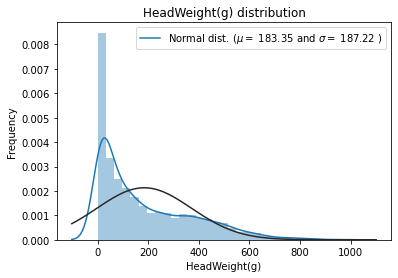

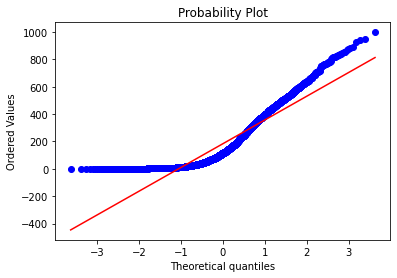

In [61]:
sns.distplot(data['HeadWeight(g)'] , fit=norm);

# Getting the fitted parameters used by the function
(mu, sigma) = norm.fit(data['HeadWeight(g)'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Ploting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('HeadWeight(g) distribution')

#Getting also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['HeadWeight(g)'], plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 99.32 and sigma = 42.70



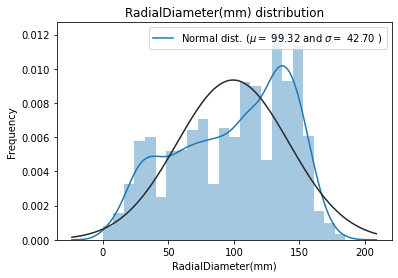

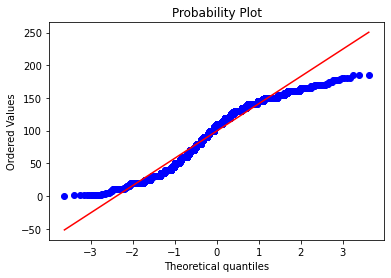

In [62]:
sns.distplot(data['RadialDiameter(mm)'] , fit=norm);

# Getting the fitted parameters used by the function
(mu, sigma) = norm.fit(data['RadialDiameter(mm)'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Ploting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('RadialDiameter(mm) distribution')

#Getting also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['RadialDiameter(mm)'], plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 96.55 and sigma = 34.91



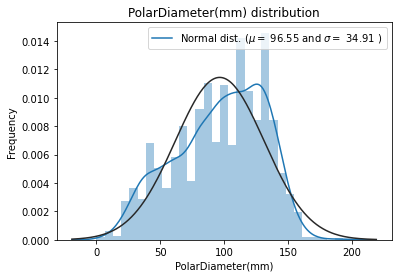

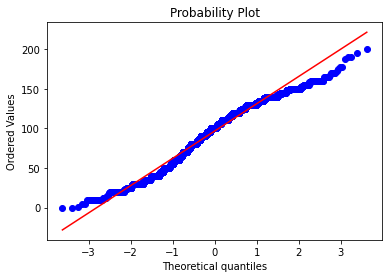

In [63]:
sns.distplot(data['PolarDiameter(mm)'] , fit=norm);

# Getting the fitted parameters used by the function
(mu, sigma) = norm.fit(data['PolarDiameter(mm)'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Ploting the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('PolarDiameter(mm) distribution')

#Getting also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['PolarDiameter(mm)'], plot=plt)
plt.show()

In [64]:
data.columns = ['BatchNumber', 'Class', 'FreshWeight(g)', 'HeadWeight(g)',
       'RadialDiameter(mm)', 'PolarDiameter(mm)', 'DiameterRatio', 'Leaves',
       'Density(kg/L)', 'LeafArea(cm2)', 'SquareID', 'SolarRadiationavg',
       'Precipitationsum', 'Wind Speedavg', 'Wind Speedmax',
       'BatteryVoltagelast', 'LeafWetnesstime', 'AirTemperatureavg',
       'AirTemperaturemax', 'AirTemperaturemin', 'RelativeHumidityavg',
       'DewPointavg', 'DewPointmin', 'ET0result', 'number_of_days',
       'Plantmonth', 'PlantDay']

In [65]:
X  = data.drop(['HeadWeight(g)', 'RadialDiameter(mm)', 'PolarDiameter(mm)',"Leaves"], axis  = 1)
y = data[['HeadWeight(g)', 'RadialDiameter(mm)', 'PolarDiameter(mm)']]

In [66]:
X.shape

(4754, 23)

In [67]:
X.isnull().sum()

BatchNumber               0
Class                     0
FreshWeight(g)            0
DiameterRatio             2
Density(kg/L)            82
LeafArea(cm2)             1
SquareID                  0
SolarRadiationavg       174
Precipitationsum        174
Wind Speedavg           174
Wind Speedmax           174
BatteryVoltagelast      174
LeafWetnesstime         174
AirTemperatureavg       174
AirTemperaturemax       174
AirTemperaturemin       174
RelativeHumidityavg     174
DewPointavg             174
DewPointmin             174
ET0result               174
number_of_days         1492
Plantmonth              174
PlantDay                174
dtype: int64

Initiating modelling using Xgboost and Lightgbm and Cross Validation using K Folds

In [68]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.metrics import mean_squared_error,r2_score

errcb=[]
y_pred_totcb=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
splits = 5
fold=KFold(n_splits=splits)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

    clf_xgb =  MultiOutputRegressor(model_xgb).fit(X_train, y_train)

    xgb_pred = clf_xgb.predict(X_test)
  
    print("folds")
    print("--------------------------------------------------------------------------------------------------")
    print("xgb mean squared error of HeadWeight {0}".format(mean_squared_error(y_test["HeadWeight(g)"], xgb_pred[:,:1])))
    print("xgb mean squared error of RadialDiameter {0}".format(mean_squared_error(y_test["RadialDiameter(mm)"], xgb_pred[:,1:2])))
    print("xgb mean squared error of PolarDiameter {0}".format(mean_squared_error(y_test["PolarDiameter(mm)"], xgb_pred[:,2:])))
  

folds
--------------------------------------------------------------------------------------------------
xgb mean squared error of HeadWeight 11672.142440102274
xgb mean squared error of RadialDiameter 360.0181813085388
xgb mean squared error of PolarDiameter 350.00275071303986
folds
--------------------------------------------------------------------------------------------------
xgb mean squared error of HeadWeight 8839.714284179741
xgb mean squared error of RadialDiameter 390.4538048762284
xgb mean squared error of PolarDiameter 368.1751077489391
folds
--------------------------------------------------------------------------------------------------
xgb mean squared error of HeadWeight 13652.70046874469
xgb mean squared error of RadialDiameter 257.1333634339991
xgb mean squared error of PolarDiameter 184.64798263012352
folds
--------------------------------------------------------------------------------------------------
xgb mean squared error of HeadWeight 1772.7698597367526
xgb m

In [69]:
errcb=[]
y_pred_totcb=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
splits = 5
fold=KFold(n_splits=splits)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_lgb = LGBMRegressor(learning_rate=0.05, max_depth=3 )


    clf_lgb =  MultiOutputRegressor(model_lgb).fit(X_train, y_train)

    lgb_pred  = clf_lgb.predict(X_test)
  
    print("folds")
    print("--------------------------------------------------------------------------------------------------")
    print("lgb mean squared error of HeadWeight {0}".format(mean_squared_error(y_test["HeadWeight(g)"], lgb_pred[:,:1])))
    print("lgb mean squared error of RadialDiameter {0}".format(mean_squared_error(y_test["RadialDiameter(mm)"], lgb_pred[:,1:2])))
    print("lgb mean squared error of PolarDiameter {0}".format(mean_squared_error(y_test["PolarDiameter(mm)"], lgb_pred[:,2:])))

folds
--------------------------------------------------------------------------------------------------
lgb mean squared error of HeadWeight 8833.634116774767
lgb mean squared error of RadialDiameter 449.1075114854583
lgb mean squared error of PolarDiameter 407.92561332742974
folds
--------------------------------------------------------------------------------------------------
lgb mean squared error of HeadWeight 3611.7572025516743
lgb mean squared error of RadialDiameter 183.7307341753888
lgb mean squared error of PolarDiameter 195.82979769614192
folds
--------------------------------------------------------------------------------------------------
lgb mean squared error of HeadWeight 11256.849403125927
lgb mean squared error of RadialDiameter 228.46416098884455
lgb mean squared error of PolarDiameter 259.78731831702976
folds
--------------------------------------------------------------------------------------------------
lgb mean squared error of HeadWeight 1491.1369337505414
lg

In [70]:
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)

In [71]:
# model_lgb = LGBMRegressor(learning_rate=0.05, max_depth=3)

In [72]:
# model1 = MultiOutputRegressor(model_xgb).fit(X_train, y_train)
# model2  = MultiOutputRegressor(model_lgb).fit(X_train, y_train)

In [73]:
# xgb_pred  = model1.predict(X_test)
# lgb_pred  = model2.predict(X_test)

In [74]:
y_test

,HeadWeight(g),RadialDiameter(mm),PolarDiameter(mm)
3804,58.0,80.0,83.0
3805,84.0,90.0,130.0
3806,83.0,105.0,94.0
3807,174.0,113.0,95.0
3808,120.0,100.0,88.0
...,...,...,...
4749,12.0,50.0,55.0
4750,8.0,45.0,85.0
4751,23.0,60.0,80.0
4752,10.0,45.0,80.0


#Evaluting the performance of our Models

Xgboost Evaluation

In [75]:
from sklearn.metrics import mean_squared_error,r2_score
print("xgb mean squared error of HeadWeight {0}".format(mean_squared_error(y_test["HeadWeight(g)"], xgb_pred[:,:1])))
print("xgb mean squared error of RadialDiameter {0}".format(mean_squared_error(y_test["RadialDiameter(mm)"], xgb_pred[:,1:2])))
print("xgb mean squared error of PolarDiameter {0}".format(mean_squared_error(y_test["PolarDiameter(mm)"], xgb_pred[:,2:])))

xgb mean squared error of HeadWeight 1769.1406238356717
xgb mean squared error of RadialDiameter 393.21781108681813
xgb mean squared error of PolarDiameter 625.4095246867812


In [76]:
print("xgb r2_score of HeadWeight {0}".format(r2_score(y_test["HeadWeight(g)"], xgb_pred[:,:1])))
print("xgb r2_score of RadialDiameter {0}".format(r2_score(y_test["RadialDiameter(mm)"], xgb_pred[:,1:2])))
print("xgb r2_score of PolarDiameter {0}".format(r2_score(y_test["PolarDiameter(mm)"], xgb_pred[:,2:])))

xgb r2_score of HeadWeight 0.7108986656128788
xgb r2_score of RadialDiameter 0.6065661298535829
xgb r2_score of PolarDiameter 0.2715373916852185


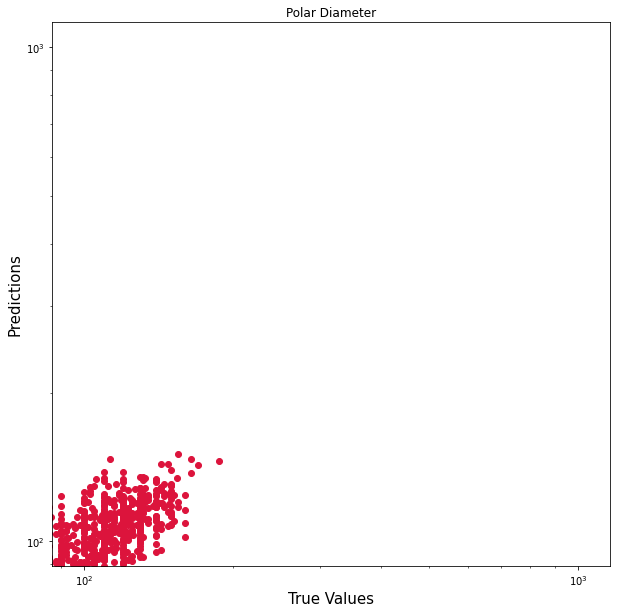

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(y_test["PolarDiameter(mm)"], xgb_pred[:,2:], c='crimson')
plt.yscale('log')
plt.xscale('log')


plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Polar Diameter")
plt.show()

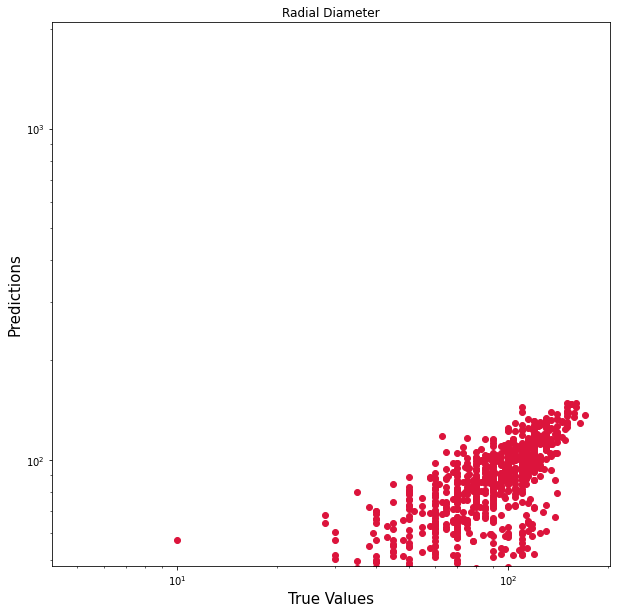

In [78]:
plt.figure(figsize=(10,10))
plt.scatter(y_test["RadialDiameter(mm)"], xgb_pred[:,1:2], c='crimson')
plt.yscale('log')
plt.xscale('log')


plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Radial Diameter")
plt.show()

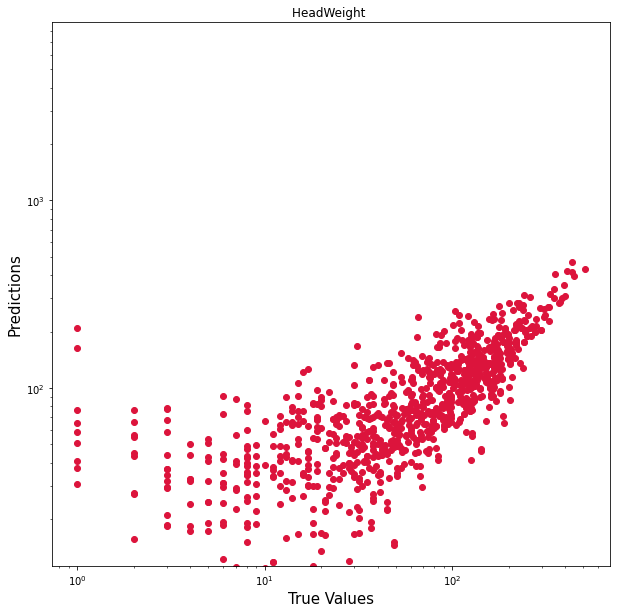

In [79]:
plt.figure(figsize=(10,10))
plt.scatter(y_test["HeadWeight(g)"], xgb_pred[:,:1], c='crimson')
plt.yscale('log')
plt.xscale('log')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("HeadWeight ")
plt.show()

Lightgbm evaluation

In [80]:
from sklearn.metrics import mean_squared_error,r2_score
print("lgb mean squared error of HeadWeight {0}".format(mean_squared_error(y_test["HeadWeight(g)"], lgb_pred[:,:1])))
print("lgb mean squared error of RadialDiameter {0}".format(mean_squared_error(y_test["RadialDiameter(mm)"], lgb_pred[:,1:2])))
print("lgb mean squared error of PolarDiameter {0}".format(mean_squared_error(y_test["PolarDiameter(mm)"], lgb_pred[:,2:])))

lgb mean squared error of HeadWeight 1601.3022353672457
lgb mean squared error of RadialDiameter 396.2580928073796
lgb mean squared error of PolarDiameter 639.0108581927585


In [81]:
print("lgb r2_score of HeadWeight {0}".format(r2_score(y_test["HeadWeight(g)"], lgb_pred[:,:1])))
print("lgb r2_score of RadialDiameter {0}".format(r2_score(y_test["RadialDiameter(mm)"], lgb_pred[:,1:2])))
print("lgb r2_score of PolarDiameter {0}".format(r2_score(y_test["PolarDiameter(mm)"], lgb_pred[:,2:])))

lgb r2_score of HeadWeight 0.738325712063491
lgb r2_score of RadialDiameter 0.6035241776074476
lgb r2_score of PolarDiameter 0.2556948717183446


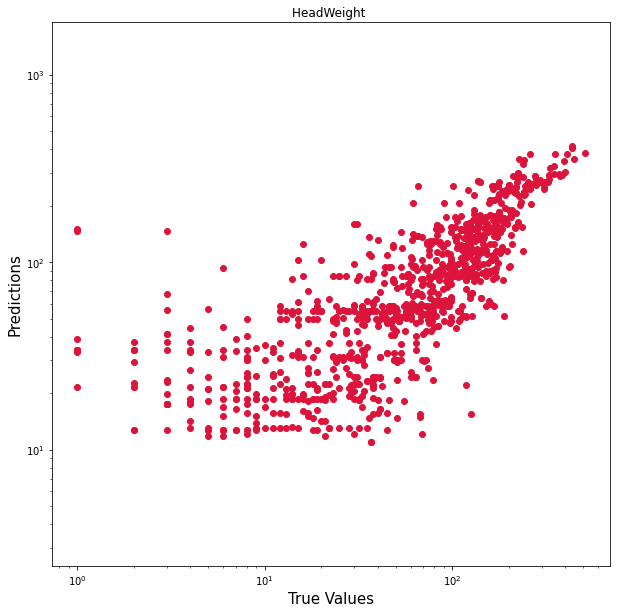

In [82]:
plt.figure(figsize=(10,10))
plt.scatter(y_test["HeadWeight(g)"], lgb_pred[:,:1], c='crimson')
plt.yscale('log')
plt.xscale('log')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("HeadWeight ")
plt.show()

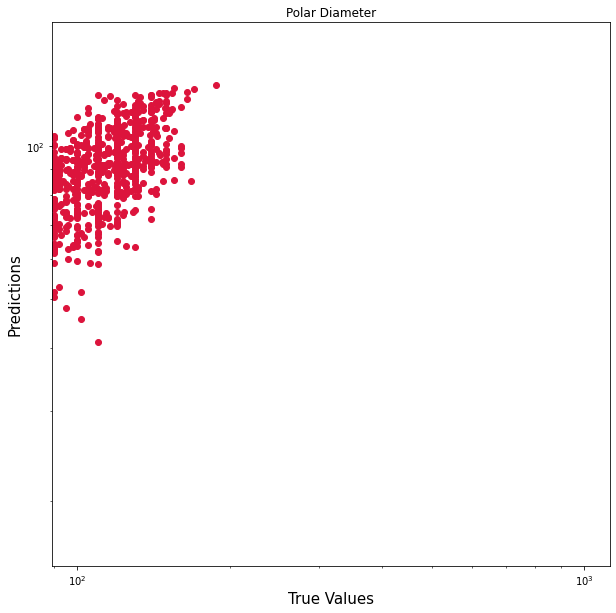

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(y_test["PolarDiameter(mm)"], lgb_pred[:,2:], c='crimson')
plt.yscale('log')
plt.xscale('log')


plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Polar Diameter")
plt.show()

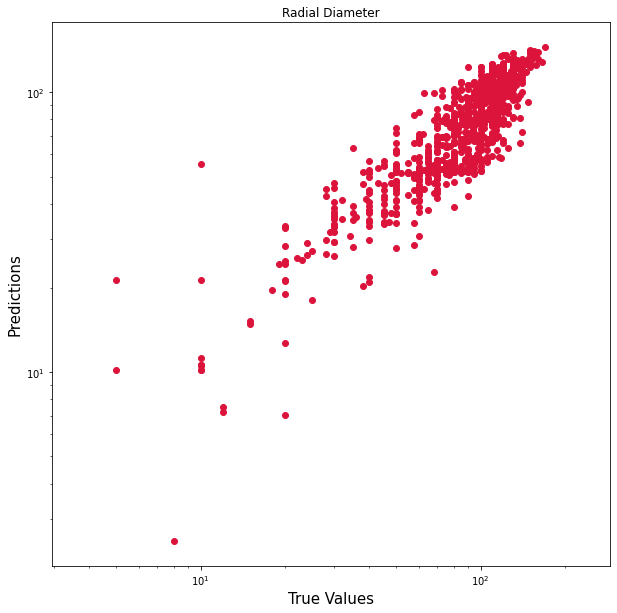

In [84]:
plt.figure(figsize=(10,10))
plt.scatter(y_test["RadialDiameter(mm)"], lgb_pred[:,1:2], c='crimson')
plt.yscale('log')
plt.xscale('log')


plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title("Radial Diameter")
plt.show()

Train Test Split to split 20% of the data for testing

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
xgb_pred  = clf_xgb.predict(X_test)

In [87]:
xgb_pred

array([[333.52255 , 144.01125 , 149.5491  ],
       [469.77884 , 153.87444 , 125.108826],
       [846.0636  , 152.94135 , 141.69896 ],
       ...,
       [ 18.119246,  73.75256 , 100.74062 ],
       [116.02455 ,  91.520905,  93.45905 ],
       [450.09344 , 143.63472 , 136.34186 ]], dtype=float32)

In [88]:
 Prediction = pd.DataFrame(xgb_pred, 
             columns=['HeadWeight(g)', 'RadialDiameter(mm)',	'PolarDiameter(mm)'])

In [89]:
Prediction

,HeadWeight(g),RadialDiameter(mm),PolarDiameter(mm)
0,333.522552,144.011246,149.549103
1,469.778839,153.874435,125.108826
2,846.063599,152.941345,141.698959
3,132.176239,98.894905,109.121880
4,20.014797,37.469898,39.121986
...,...,...,...
946,29.525684,66.468369,58.692196
947,378.447937,132.479965,121.677452
948,18.119246,73.752563,100.740623
949,116.024551,91.520905,93.459053


In [90]:
#Converting predictions to csv
pd.DataFrame(Prediction).to_csv('Yield_Prediction.csv', index=False)